# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** xx

**Author 1 (sciper):** Nicolas Martinod (xxxxx)  
**Author 2 (sciper):** Nicolas Feppon (249799)   
**Author 3 (sciper):** Victor Dramé (270624)   

**Release date:** 23.04.2021  
**Due date:** 07.05.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = 'gdrive/My Drive/IAPR - TP/data/'
data_folder = 'lab-03-data'
# tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
# with tarfile.open(tar_path, mode='r:gz') as tar:
#     tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

data_part1_path = os.path.join('lab-03-data', 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


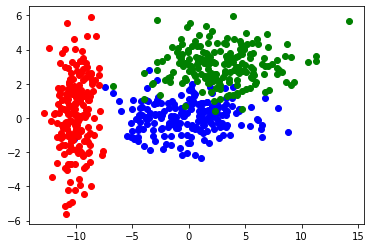

In [265]:
from matplotlib import pyplot as plt
import cv2
plt.plot(a[:,0],a[:,1],'bo')
plt.plot(b[:,0],b[:,1],'go')
plt.plot(c[:,0],c[:,1],'ro')


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

 We also consider each class to have the same priors as we have 200 sample from each, thus P(Wi)=1/3 for each class.

In [281]:
# Add your implementation and discussion
import numpy as np
from numpy import linalg as LA

#compute the mean and covariance of a data set
def compute_mean_cov(data):
    return np.mean(data,0), np.cov(data.T)

# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, cov):
    numerator = np.exp(-0.5*np.dot((x-mean).T,LA.inv(cov)),(x-mean))
    return (1 / (2 * np.pi * LA.det(cov))) * numerator

#compute the discriminant function
def compute_g(x_data_range,y_data_range,mean,cov):
    """
    x_data_range: range of the data set on x
    y_data_range: range of the data set on y
    """
    g=np.zeros((np.size(x_data_range),np.size(y_data_range)))
    #compute the discriminant function for each point in range
    for x_idx,x in enumerate(x_data_range):
        for y_idx,y in enumerate(y_data_range):
            pt=np.array([y,x])
            g[x_idx,y_idx]=1/2*(-pt.T@LA.inv(cov)@pt+pt.T@LA.inv(cov)@mean -mean.T@LA.inv(cov)@mean\
                                +mean.T@LA.inv(cov)@pt) -np.log(2*np.pi*LA.det(cov))
    return g

#compute class edge and return it as a set of point
def class_edge_finder(g_1,g_2):
    #set value lower than the threshold value to 0 and higher value to max
    edge_threshold=0
    ret, thresh = cv2.threshold(g_1-g_2, edge_threshold, 255, 0)
    #plt.plot(thresh)
    edges = cv2.Canny(np.uint8(thresh),1,1,)
    class_edge=np.argwhere(edges>0)
    #set in the right range
    class_edge[:,0]= class_edge[:,0]-6
    class_edge[:,1]= class_edge[:,1]-15

    return class_edge

#return the probability to be in the 3 classes.
def get_class_prob(x,a,b,c):
    mean_a,cov_a=compute_mean_cov(a)
    mean_b,cov_b=compute_mean_cov(b)
    mean_c,cov_c=compute_mean_cov(c)
    #compute each probability
    p_a=calculate_probability(x,mean_a,cov_a)
    p_b=calculate_probability(x,mean_b,cov_b)
    p_c=calculate_probability(x,mean_c,cov_c)
    
    return p_a,p_b,p_c


In [267]:
mean_a,cov_a=compute_mean_cov(a)
mean_b,cov_b=compute_mean_cov(b)
mean_c,cov_c=compute_mean_cov(c)

print('cov a:\n',cov_a)
print('cov b:\n',cov_b)
print('cov c:\n',cov_c)

cov a:
 [[10.02769733  0.13162336]
 [ 0.13162336  0.83932673]]
cov b:
 [[10.17034812  0.18023771]
 [ 0.18023771  1.0840038 ]]
cov c:
 [[0.97013029 0.23458112]
 [0.23458112 4.69756273]]


In [269]:
#data range
x_range=range(-6,6)
y_range=range(-15,15)
#compute discriminant function
g_a=compute_g(x_range,y_range,mean_a,cov_a)
g_b=compute_g(x_range,y_range,mean_b,cov_b)
g_c=compute_g(x_range,y_range,mean_c,cov_c)

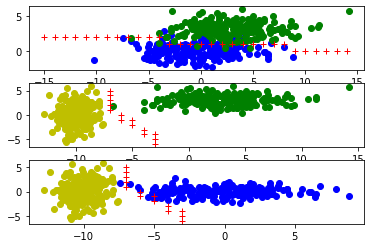

In [278]:

#classifier AB
plt.subplot(311)
edge_ab=class_edge_finder(g_a,g_b)
plt.plot(a[:,0],a[:,1],'bo')
plt.plot(b[:,0],b[:,1],'go')
#in this order since argwhere return
plt.plot(edge_ab[:,1],edge_ab[:,0],'r+')

#Classifier BC
plt.subplot(312)
edge_bc=class_edge_finder(g_b,g_c)
plt.plot(b[:,0],b[:,1],'go')
plt.plot(c[:,0],c[:,1],'yo')
#in this order since argwhere return
plt.plot(edge_bc[:,1],edge_bc[:,0],'r+')

#Classifier AC
plt.subplot(313)
edge_ac=class_edge_finder(g_b,g_c)
plt.plot(a[:,0],a[:,1],'bo')
plt.plot(c[:,0],c[:,1],'yo')
#in this order since argwhere return
plt.plot(edge_ac[:,1],edge_ac[:,0],'r+')

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

In [ ]:
# Add your implementation and discussion

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [ ]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [ ]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [ ]:
# Add your implementation and discussion